In [1]:
import itertools
import warnings

import cvxopt
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class SVM:
    """Class implementing a Support Vector Machine: 
    Instead of minimising the primal function
        L_P(w, b, lambda_mat) = 1/2 ||w||^2 - sum_i{lambda_i[(w * x + b) - 1]},
    we maximize the dual function
        L_D(lambda_mat) = sum_i{lambda_i} - 1/2 sum_i{sum_j{lambda_i lambda_j y_i y_j K(x_i, x_j)}}.

    Parameters
    ----------
    kernel : {"linear", "rbf", "poly", "sigmoid"}
        Type of kernel function.
    gamma : float or None, default=None
        Value representing the gamma parameter of the kernel; if None, it will be computed automatically during fit.
    deg : int, default=3
        Value representing the degree of the "poly" kernel function.
    r : float, default=0.
        Value representing the r parameter of "poly" and "sigmoid" kernel functions.
    c : float or None, default=1.
        Value regulating the trade-off between the amount of misclassified samples and the size of the margin
        (its "softness" decreases as C increases); if None, hard margin is employed (no tolerance towards
        misclassified samples).

    Attributes
    ----------
    _kernel : {"linear", "rbf", "poly", "sigmoid"}
        Type of kernel function.
    _kernel_fn : function
        Kernel function.
    _gamma : float or None
        Value representing the gamma parameter of the kernel; if None, it will be computed automatically during fit.
    _lambdas : ndarray or None
        Lagrangian multipliers.
    _sv_x : ndarray or None
        Support vectors related to X.
    _sv_y : ndarray or None
        Support vectors related to y.
    _w : ndarray or None
        Matrix of hyperplane parameters.
    _b : float or None
        Hyperplane bias.
    _c : float or None
        Value regulating the trade-off between the amount of misclassified samples and the size of the margin
        (its "softness" decreases as C increases); if None, hard margin is employed (no tolerance towards
        misclassified samples).
    _is_fit : bool
        Whether the SVM is fit or not.
    """

    def __init__(
            self,
            kernel: str = "linear",
            gamma: float | None = None,
            deg: int = 3,
            r: float = 0.,
            c: float | None = 1.
    ):
        # Lagrangian's multipliers, hyperparameters and support vectors are initially set to None
        self._lambdas = None
        self._sv_x = None
        self._sv_y = None
        self._w = None
        self._b = None

        # If gamma is None, it will be computed during fit process
        self._gamma = gamma

        # Assign the right kernel
        self._kernel = kernel
        if kernel == "linear":
            self._kernel_fn = lambda x_i, x_j: np.dot(x_i, x_j)
        elif kernel == "rbf":
            self._kernel_fn = lambda x_i, x_j: np.exp(-self._gamma * np.dot(x_i - x_j, x_i - x_j))
        elif kernel == "poly":
            self._kernel_fn = lambda x_i, x_j: (self._gamma * np.dot(x_i, x_j) + r) ** deg
        elif kernel == "sigmoid":
            self._kernel_fn = lambda x_i, x_j: np.tanh(np.dot(x_i, x_j) + r)

        # Soft margin
        self._c = c

        self._is_fit = False

    def fit(self, x: np.ndarray, y: np.ndarray, verbosity: int = 1) -> None:
        """Fit the SVM on the given training set.

        Parameters
        ----------
        x : ndarray
            Training data with shape (n_samples, n_features).
        y : ndarray
            Ground-truth labels.
        verbosity : int, default=1
            Verbosity level in range [0, 3].
        """
        # If "verbosity" is outside range [0, 3], set it to default (1)
        if verbosity not in {0, 1, 2}:
            verbosity = 1

        n_samples, n_features = x.shape
        # If gamma was not specified in "__init__", it is set according to the "scale" approach
        if not self._gamma:
            self._gamma = 1 / (n_features * x.var())

        # max{L_D(Lambda)} can be rewritten as
        #   min{1/2 Lambda^T H Lambda - 1^T Lambda}
        #       s.t. -lambda_i <= 0
        #       s.t. lambda_i <= c
        #       s.t. y^t Lambda = 0
        # where H[i, j] = y_i y_j K(x_i, x_j)
        # This form is conform to the signature of the quadratic solver provided by CVXOPT library:
        #   min{1/2 x^T P x + q^T x}
        #       s.t. G x <= h
        #       s.t. A x = b
        k = np.zeros(shape=(n_samples, n_samples))
        for i, j in itertools.product(range(n_samples), range(n_samples)):
            k[i, j] = self._kernel_fn(x[i], x[j])
        p = cvxopt.matrix(np.outer(y, y) * k)
        q = cvxopt.matrix(-np.ones(n_samples))
        # Compute G and h matrix according to the type of margin used
        if self._c:
            g = cvxopt.matrix(np.vstack((
                -np.eye(n_samples),
                np.eye(n_samples)
            )))
            h = cvxopt.matrix(np.hstack((
                np.zeros(n_samples),
                np.ones(n_samples) * self._c
            )))
        else:
            g = cvxopt.matrix(-np.eye(n_samples))
            h = cvxopt.matrix(np.zeros(n_samples))
        a = cvxopt.matrix(y.reshape(1, -1).astype(np.double))
        b = cvxopt.matrix(np.zeros(1))

        # Set CVXOPT options
        cvxopt.solvers.options["show_progress"] = False
        cvxopt.solvers.options["maxiters"] = 200

        # Compute the solution using the quadratic solver
        try:
            sol = cvxopt.solvers.qp(p, q, g, h, a, b)
        except ValueError as e:
            print(f"Impossible to fit, try to change kernel parameters; CVXOPT raised Value Error: {e:s}")
            return
        # Extract Lagrange multipliers
        lambdas = np.ravel(sol["x"])
        # Find indices of the support vectors, which have non-zero Lagrange multipliers, and save the support vectors
        # as instance attributes
        if self._c:
            is_sv = (lambdas >= 1e-5) & (lambdas <= self._c)
        else:
            is_sv = lambdas >= 1e-5
        self._sv_x = x[is_sv]
        self._sv_y = y[is_sv]
        self._lambdas = lambdas[is_sv]
        # Compute b as 1/N_s sum_i{y_i - sum_sv{lambdas_sv * y_sv * K(x_sv, x_i}}
        sv_index = np.arange(len(lambdas))[is_sv]
        self._b = 0
        for i in range(len(self._lambdas)):
            self._b += self._sv_y[i]
            self._b -= np.sum(self._lambdas * self._sv_y * k[sv_index[i], is_sv])
        self._b /= len(self._lambdas)
        # Compute w only if the kernel is linear
        if self._kernel == "linear":
            self._w = np.zeros(n_features)
            for i in range(len(self._lambdas)):
                self._w += self._lambdas[i] * self._sv_x[i] * self._sv_y[i]
        else:
            self._w = None
        self._is_fit = True

        # Print results according to verbosity
        if verbosity in {1, 2}:
            print(f"{len(self._lambdas):d} support vectors found out of {n_samples:d} data points")
            if verbosity == 2:
                for i in range(len(self._lambdas)):
                    print(f"{i + 1:d}) X: {self._sv_x[i]}\ty: {self._sv_y[i]}\tlambda: {self._lambdas[i]:.2f}")
            print(f"Bias of the hyper-plane: {self._b:.3f}")
            print("Weights of the hyper-plane:", self._w)

    def project(
            self,
            x: np.ndarray,
            i: int | None = None,
            j: int | None = None
    ) -> np.ndarray:
        """Project data on the hyperplane.

        Parameters
        ----------
        x : ndarray
            Data points with shape (n_samples, n_features).
        i : int or None, default=None
            First dimension to plot (in the case of non-linear kernels).
        j : int or None, default=None
            Second dimension to plot (in the case of non-linear kernels).

        Returns
        -------
        ndarray
            Projection of the points on the hyperplane.
        """
        # If the model is not fit, raise an exception
        if not self.is_fit:
            raise SVMNotFitError
        # If the kernel is linear and "w" is defined, the value of f(x) is determined by
        #   f(x) = X * w + b
        if self._w is not None:
            return np.dot(x, self._w) + self._b
        else:
            # Otherwise, it is determined by
            #   f(x) = sum_i{sum_sv{lambda_sv y_sv K(x_i, x_sv)}}
            y_predict = np.zeros(len(x))
            for k in range(len(x)):
                for lda, sv_x, sv_y in zip(self._lambdas, self._sv_x, self._sv_y):
                    # Extract the two dimensions from sv_x if "i" and "j" are specified
                    if i or j:
                        sv_x = np.array([sv_x[i], sv_x[j]])

                    y_predict[k] += lda * sv_y * self._kernel_fn(x[k], sv_x)
            return y_predict + self._b

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Predict the class of the given data points.

        Parameters
        ----------
        x : ndarray
            Data points with shape (n_samples, n_features).

        Returns
        -------
        ndarray
            Predicted labels.
        """
        # To predict the point label, only the sign of f(x) is considered
        return np.sign(self.project(x))

    def plot2d(
            self,
            x: np.ndarray,
            y: np.ndarray,
            x_min: float | None = None,
            x_max: float | None = None,
            y_min: float | None = None,
            y_max: float | None = None
    ) -> None:
        """Display the plots of data points color coded by predicted labels and margins.

        Parameters
        ----------
        x : ndarray
            Data points with shape (n_samples, n_features).
        y : ndarray
            Ground-truth labels.
        x_min : float or None, default=None
            Maximum x coordinate for the plot.
        x_max : float or None, default=None
            Minimum x coordinate for the plot.
        y_min : float or None, default=None
            Maximum y coordinate for the plot.
        y_max : float or None, default=None
            Minimum y coordinate for the plot.
        """
        # Get indexes of positive and negative labels
        is_pos = y > 0
        is_neg = y < 0

        # Get number of pairs to plot
        n_samples, n_features = x.shape
        pair_plots = list(itertools.combinations(np.arange(start=0, stop=n_features, step=1, dtype=int), 2))
        num_plots = len(pair_plots)
        if num_plots % 2 != 0:
            num_plots += 1

        # Check number of features
        if n_features > 2:
            # If the number of features is higher than 2, initialize a grid of subplots
            fig, ax = plt.subplots(nrows=num_plots // 2, ncols=2, figsize=(15, 30))
        elif n_features == 2:
            # If the number of features is 2, draw a single plot and wrap it in a fake grid
            fig, ax = plt.subplots(figsize=(15, 10))
            ax = np.array([
                [ax, 0],
                [0, 0]
            ])
        else:
            # Otherwise, return
            print("Number of dimensions must be 2 or higher.")
            return

        # Initialize plot counters
        p_i, p_j = 0, 0

        # Iterate over dimensions
        for i, j in pair_plots:
            # If bounds are not specified, compute them from maximum and minimum data
            if not x_min:
                x_min = np.min(x[:, i]) - 1
            if not x_max:
                x_max = np.max(x[:, i]) + 1
            if not y_min:
                y_min = np.min(x[:, j]) - 1
            if not y_max:
                y_max = np.max(x[:, j]) + 1

            # Initialize subplot
            ax[p_i, p_j].title.set_text(f"Dimensions {i:d}, {j:d}")
            ax[p_i, p_j].grid(True, which="both")
            ax[p_i, p_j].axhline(y=0, color="k")
            ax[p_i, p_j].axvline(x=0, color="k")

            # Plot training set points
            ax[p_i, p_j].plot(x[is_pos, i], x[is_pos, j], "bo")
            ax[p_i, p_j].plot(x[is_neg, i], x[is_neg, j], "ro")
            # Plot support vectors
            ax[p_i, p_j].scatter(self._sv_x[:, i], self._sv_x[:, j], s=100, c="g")

            # If the kernel is linear and "w" is defined, the hyperplane can be plotted using "w" and "b"
            if self._w is not None:
                # Function representing the hyperplane
                def f(x_: np.ndarray, w_0: float, w_1: float, b: float, c: float = 0):
                    return -(w_0 * x_ + b - c)/w_1

                # Plot the hyperplane
                x_s = np.linspace(x_min, x_max)
                ax[p_i, p_j].plot(x_s, f(x_s, self._w[i], self._w[j], self._b), "k")
                ax[p_i, p_j].plot(x_s, f(x_s, self._w[i], self._w[j], self._b, -1), "k--")
                ax[p_i, p_j].plot(x_s, f(x_s, self._w[i], self._w[j], self._b, 1), "k--")

            else:
                # Plot the contours of the decision function
                x1, x2 = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
                xs = np.array([[x1_, x2_] for x1_, x2_ in zip(np.ravel(x1), np.ravel(x2))])
                z = self.project(xs, i, j).reshape(x1.shape)

                # Suppress warnings and reactivate them after plotting contour
                warnings.filterwarnings("ignore")
                ax[p_i, p_j].contour(x1, x2, z, [0.], colors="k", linewidths=1, origin="lower")
                ax[p_i, p_j].contour(x1, x2, z + 1, [0.], colors="grey", linewidths=1, origin="lower")
                ax[p_i, p_j].contour(x1, x2, z - 1, [0.], colors="grey", linewidths=1, origin="lower")
                warnings.filterwarnings("default")

            ax[p_i, p_j].set(xlim=(x_min, x_max), ylim=(y_min, y_max))

            # Increment subplot counters
            if p_j == 0:
                p_j += 1
            else:
                p_i += 1
                p_j -= 1
        plt.show()

    @property
    def is_fit(self) -> bool:
        return self._is_fit

    @property
    def sv_x(self) -> np.ndarray:
        return self._sv_x

    @property
    def sv_y(self) -> np.ndarray:
        return self._sv_y


class SVMNotFitError(Exception):
    """Exception raised when the "project" or the "predict" method of an SVM object is called without fitting
    the model beforehand.
    """

In [4]:
import collections

import numpy as np

class MulticlassSVM:
    """Class implementing a Support Vector Machine for multi-classification purposes based on one-vs-one strategy.
    Given N different classes to classify, the algorithm provides N*(N-1)/2 SVM binary classifiers. Each classifier is
    trained to correctly classify 2 of the N given classes using in the training process only the entries in the
    dataset to which it corresponds a label of the 2 classes. Given an unseen example, the prediction of the class is
    computed deploying a voting schema among the classifiers.

    Parameters
    ----------
    kernel : {"linear", "rbf", "poly", "sigmoid"}
        Type of kernel function.
    gamma : float or None, default=None
        Value representing the gamma parameter of the kernel; if None, it will be computed automatically during fit.
    deg : int, default=3
        Value representing the degree of the "poly" kernel function.
    r : float, default=0.
        Value representing the r parameter of "poly" and "sigmoid" kernel functions.
    c : float or None, default=1
        Value regulating the trade-off between the amount of misclassified samples and the size of the margin
        (its "softness" decreases as C increases); if None, hard margin is employed (no tolerance towards
        misclassified samples).

    Attributes
    ----------
    _kernel : {"linear", "rbf", "poly", "sigmoid"}
        Type of kernel function.
    _gamma : float or None
        Value representing the gamma parameter of the kernel; if None, it will be computed automatically during fit.
    _deg : int
        Value representing the degree of the "poly" kernel function.
    _r : float
        Value representing the r parameter of "poly" and "sigmoid" kernel functions.
    _c : float or None
        Value regulating the trade-off between the amount of misclassified samples and the size of the margin
        (its "softness" decreases as C increases); if None, hard margin is employed (no tolerance towards
        misclassified samples).
    _svm_list : list of SVM
        List of triplets, each one comprising the SVM binary classifier, the label of the 1st class and the label of
        the 2nd class (1st class corresponds to sign "-", 2nd class corresponds to sign "+"); the number of binary
        SVM classifiers needed will be known only when the dataset labels are given.
    _labels : ndarray or None
        Integer labels.
    _support_vectors : set of tuple of (float, float)
        Set of support vectors.
    """

    def __init__(
            self,
            kernel: str = "linear",
            gamma: float | None = None,
            deg: int = 3,
            r: float = 0.,
            c: float | None = 1.
    ):
        # By default linear kernel is used
        self._kernel = kernel
        # If gamma is None, it will be computed during fit process
        self._gamma = gamma
        self._deg = deg
        self._r = r
        self._c = c
        self._svm_list = []
        self._labels = None
        self._support_vectors = set()

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """Fit the SVM on the given training set.

        Parameters
        ----------
        x : ndarray
            Training data with shape (n_samples, n_features).
        y : ndarray
            Ground-truth labels.
        """
        # Check if labels are integers
        labels = np.unique(y)
        for label in labels:
            if not label.is_integer():
                raise ValueError(str(label) + " is not an integer value label")
        self._labels = np.array(labels, dtype=int)

        # Re-arrange training set per labels in a dictionary
        x_arranged_list = collections.defaultdict(list)
        for index, x_ in enumerate(x):
            x_arranged_list[y[index]].append(x_)

        # Convert to numpy array the previous dictionary
        x_arranged_numpy = {}
        for index in range(len(self._labels)):
            x_arranged_numpy[index] = np.array(x_arranged_list[index])

        for i in range(0, self._labels.shape[0] - 1):
            for j in range(i + 1, self._labels.shape[0]):
                current_x = np.concatenate((x_arranged_numpy[i], x_arranged_numpy[j]))
                current_y = np.concatenate((- np.ones((len(x_arranged_numpy[i]),), dtype=int),
                                           np.ones(len((x_arranged_numpy[j]),), dtype=int)))
                svm = SVM(kernel=self._kernel, gamma=self._gamma, deg=self._deg, r=self._r, c=self._c)
                svm.fit(current_x, current_y, verbosity=0)
                for sv in svm.sv_x:
                    self._support_vectors.add(tuple(sv.tolist()))
                svm_tuple = (svm, self._labels[i], self._labels[j])
                self._svm_list.append(svm_tuple)
        print('{0:d} support vectors found out of {1:d} data points'.format(len(self._support_vectors), len(x)))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Predict the class of the given data points. The voting process is based on the standard predict function
        for binary SVM classifiers, so the input entry is assigned to the class which wins the highest number of binary
        comparisons; to counteract the possible risk of draw, the predicted value before the application of the "sign"
        function in binary classifiers is stored as well.
        For each sample j, for each label i:
            - voting_schema[j][0][i] is the number of total comparisons won
            - voting_schema[j][1][i] is the cumulative sum of predicted values

        Parameters
        ----------
        x : ndarray
            Data points with shape (n_samples, n_features).

        Returns
        -------
        ndarray
            Results of the voting scheme.
        """
        voting_schema = np.zeros([len(x), 2, self._labels.shape[0]], dtype=float)
        for svm_tuple in self._svm_list:
            prediction = svm_tuple[0].project(x)
            for i in range(len(prediction)):
                if prediction[i] < 0:
                    voting_schema[i][0][svm_tuple[1]] += 1
                    voting_schema[i][1][svm_tuple[1]] += -1 * prediction[i]
                else:
                    voting_schema[i][0][svm_tuple[2]] += 1
                    voting_schema[i][1][svm_tuple[2]] += prediction[i]

        voting_results = np.zeros(len(voting_schema), dtype=int)
        for i in range(len(voting_schema)):
            sorted_votes = np.sort(voting_schema[i][0])
            # If the first two classes received a different number of votes there is no draw
            if sorted_votes[0] > sorted_votes[1]:
                voting_results[i] = voting_schema[i][0].argmax()
            # Otherwise return label of the class which has the highest cumulative sum of predicted values
            else:
                voting_results[i] = voting_schema[i][1].argmax()

        return voting_results

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles
from typing import Optional


def linear_data_generator(
        n_samples: int,
        n_features: int,
        random_state: int | None = None
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    x, y = make_blobs(n_samples, n_features, centers=2, cluster_std=2.0, random_state=random_state)
    # Assign '-1' instead of '0'
    is_zero = y < 1
    y[is_zero] = -1
    return train_test_split(x, y, random_state=random_state)

/var/folders/1j/fkh65h0d05z0bwmnqx4w1rd80000gn/T/ipykernel_26661/2641905227.py:335: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'or', color="black", markersize=20)
/var/folders/1j/fkh65h0d05z0bwmnqx4w1rd80000gn/T/ipykernel_26661/2641905227.py:336: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'or', color="white", markersize=18)


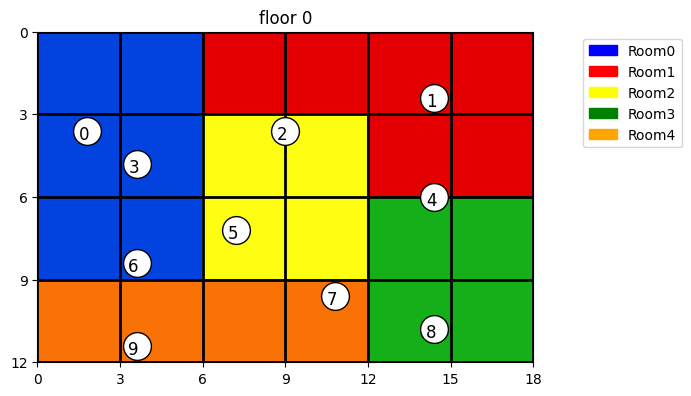

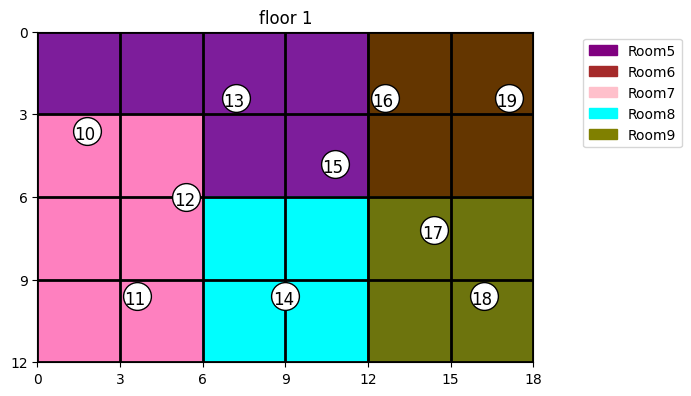

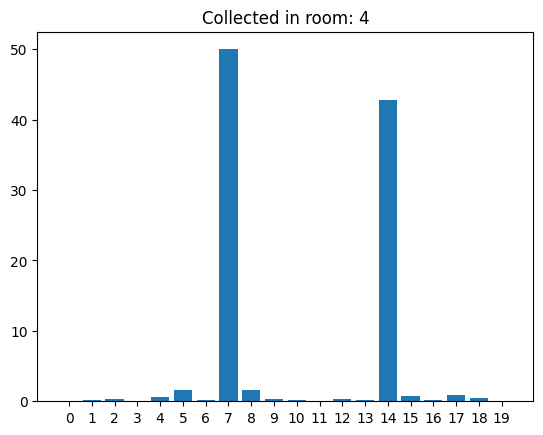

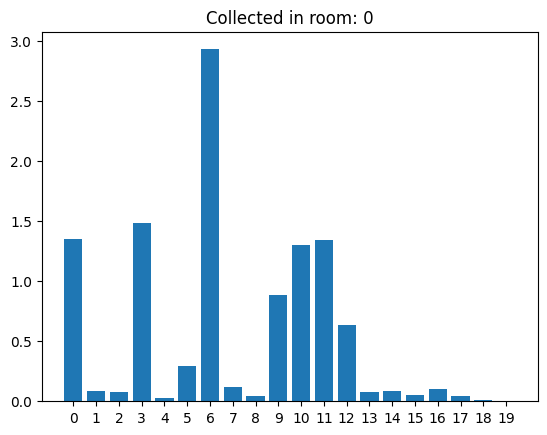

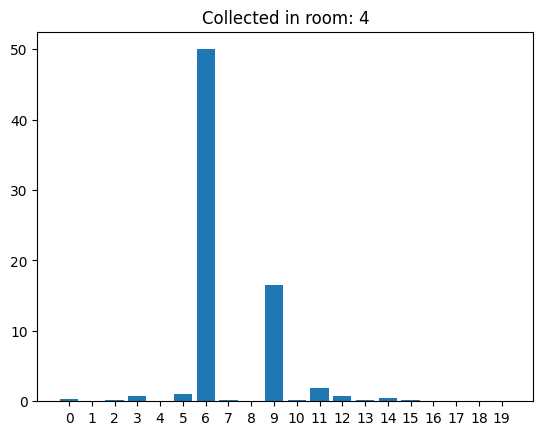

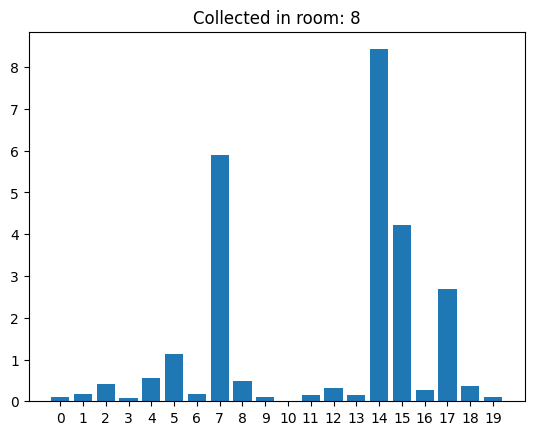

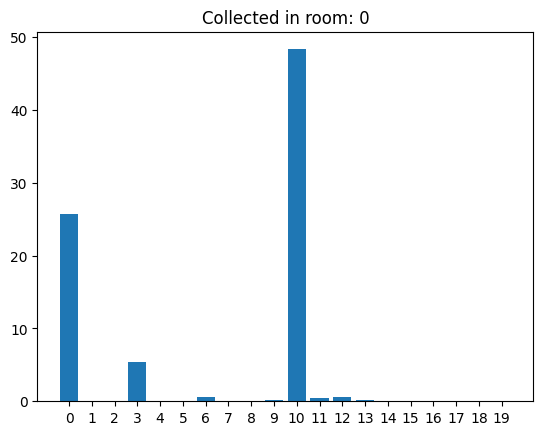

In [6]:
import math
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as m_patches


def create_10_rooms():
    # x, y (in meters) dimension of the plant of the building, each floor is 3 meters height
    max_x = 12
    max_y = 18
    floor_number = 2

    if max_x % 3 != 0 or max_y % 3 != 0:
        print("max_x and max_y must be multiple of 3")
        exit(1)

    # supposing each room is at least 3x3 meters
    max_x /= 3
    max_y /= 3
    max_x = int(max_x)
    max_y = int(max_y)

    # WATCH OUT FOR DIMENSIONS! ADJUST PREVIOUS VALUES BEFORE MODIFICATION
    rooms_list = [
        # floor 0
        [
            [0, 0, 1, 1, 1, 1],
            [0, 0, 2, 2, 1, 1],
            [0, 0, 2, 2, 3, 3],
            [4, 4, 4, 4, 3, 3],
        ],
        # floor 1
        [
            [5, 5, 5, 5, 6, 6],
            [7, 7, 5, 5, 6, 6],
            [7, 7, 8, 8, 9, 9],
            [7, 7, 8, 8, 9, 9],
        ],
    ]

    rooms = np.array(rooms_list, dtype=int)
    name = 11  # number of color in palette + 1

    return rooms, name, max_x, max_y, floor_number


def create_2_rooms():
    # x, y (in meters) dimension of the plant of the building, each floor is 3 meters height
    max_x = 12
    max_y = 18
    floor_number = 1

    if max_x % 3 != 0 or max_y % 3 != 0:
        print("max_x and max_y must be multiple of 3")
        exit(1)

    # supposing each room is at least 3x3 meters
    max_x /= 3
    max_y /= 3
    max_x = int(max_x)
    max_y = int(max_y)

    # WATCH OUT FOR DIMENSIONS! ADJUST PREVIOUS VALUES BEFORE MODIFICATION
    rooms_list = [
        # floor 0
        [
            [0, 0, 1, 1, 1, 1],
            [0, 0, 1, 1, 1, 1],
            [0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 1, 1],
        ],
    ]

    rooms = np.array(rooms_list, dtype=int)
    name = 11  # number of color in palette + 1

    return rooms, name, max_x, max_y, floor_number


def from_hex_color(color_name):
    raw_col = colors.get_named_colors_mapping()["xkcd:" + color_name].lstrip('#')
    color = tuple(int(raw_col[i:i + 2], 16) for i in (0, 2, 4))
    return color[0] / 256.0, color[1] / 256.0, color[2] / 256.0


def fill_color(colors_np, colors_str):
    for index, string in enumerate(colors_str):
        colors_np[index] = from_hex_color(string)


def create_colors():
    # less color, better visualization! At MOST 10 rooms per floor whit this palette
    color_patches = []
    colors_str = ['blue', 'red', 'yellow', 'green', 'orange', 'purple',
                  'brown', 'pink', 'cyan', 'olive']
    colors_np = np.empty([len(colors_str), 3], dtype=float)
    fill_color(colors_np, colors_str)

    for k, color_str in enumerate(colors_str):
        color_patches.append(m_patches.Patch(color=color_str, label='Room' + str(k)))

    return colors_np, color_patches


def create_sensors_10_rooms(m_x, m_y, floor_number):
    m_z = floor_number * 3  # 3 meters per floor
    m_x *= 3  # in meters
    m_y *= 3  # in meters

    # floor 0
    sensors_0 = [(m_x * 0.3, m_y * 0.1, m_z * 0.2), (m_x * 0.2, m_y * 0.8, m_z * 0.4),
                 (m_x * 0.3, m_y * 0.5, m_z * 0.2), (m_x * 0.4, m_y * 0.2, m_z * 0.4),
                 (m_x * 0.5, m_y * 0.8, m_z * 0.2), (m_x * 0.6, m_y * 0.4, m_z * 0.4),
                 (m_x * 0.7, m_y * 0.2, m_z * 0.2), (m_x * 0.8, m_y * 0.6, m_z * 0.4),
                 (m_x * 0.9, m_y * 0.8, m_z * 0.2), (m_x * 0.95, m_y * 0.2, m_z * 0.4), ]
    # floor 1
    sensors_1 = [(m_x * 0.3, m_y * 0.1, m_z * 0.6), (m_x * 0.8, m_y * 0.2, m_z * 0.8),
                 (m_x * 0.5, m_y * 0.3, m_z * 0.6), (m_x * 0.2, m_y * 0.4, m_z * 0.8),
                 (m_x * 0.8, m_y * 0.5, m_z * 0.6), (m_x * 0.4, m_y * 0.6, m_z * 0.8),
                 (m_x * 0.2, m_y * 0.7, m_z * 0.6), (m_x * 0.6, m_y * 0.8, m_z * 0.8),
                 (m_x * 0.8, m_y * 0.9, m_z * 0.6), (m_x * 0.2, m_y * 0.95, m_z * 0.8), ]

    sensors_per_floor = []
    sensors_per_floor.append(sensors_0)
    sensors_per_floor.append(sensors_1)

    sensors_list = sensors_0 + sensors_1

    return np.array(sensors_list, dtype=float), sensors_per_floor


def create_sensors_2_rooms(m_x, m_y, floor_number):
    m_z = floor_number * 3  # 3 meters per floor
    m_x *= 3  # in meters
    m_y *= 3  # in meters

    # floor 0
    sensors_0 = [(m_x * 0.8, m_y * 0.2, m_z * 0.5), (m_x * 0.3, m_y * 0.3, m_z * 0.25),
                 (m_x * 0.5, m_y * 0.5, m_z * 0.5), (m_x * 0.7, m_y * 0.7, m_z * 0.75),
                 (m_x * 0.2, m_y * 0.8, m_z * 0.5), ]

    sensors_per_floor = []
    sensors_per_floor.append(sensors_0)

    return np.array(sensors_0, dtype=float), sensors_per_floor


def score_distance(coord, s):
    return 500 / ((coord[0] - s[0]) ** 2 + (coord[1] - s[1]) ** 2 + (coord[2] - s[2]) ** 2) ** 2


def generate_dataset(n, max_x, max_y, max_z, rooms, sensors):
    max_x *= 3  # in meters
    max_y *= 3  # in meters
    max_z *= 3  # in meters

    data = []
    data_coords = []
    for i in range(n):
        coord = (rnd.random() * max_x, rnd.random() * max_y, rnd.random() * max_z)
        data_coords.append(coord)

        label = rooms[math.floor(coord[2] / 3.0)][math.floor(coord[0] / 3.0)][math.floor(coord[1] / 3.0)]
        # storage of the intensity values measured by each sensor for each data point
        # simulate error in measurement process
        error_bias = 0.1
        entry = [score_distance(coord, s) + error_bias * rnd.random()
                 if rnd.random() < 0.5 else
                 score_distance(coord, s) - error_bias * rnd.random()
                 for s in sensors]

        # remove invalid negative values
        entry = [e if e > 0 else 0.001 * rnd.random() for e in entry]
        # smooth high values
        entry = [e if e < 50 else 50 for e in entry]

        # add class label (room)
        entry.append(label)

        data.append(entry)

    return data, data_coords


def get_sensors_labels(all_sensors, rooms):
    sensors_labels = []
    for s in all_sensors:
        sensors_labels.append(rooms[math.floor(s[2] / 3.0)][math.floor(s[0] / 3.0)][math.floor(s[1] / 3.0)])
    return sensors_labels


def sensor_input_from_spatial_position(x, y, z, sensors):
    # the input values x, y and z are supposed in meters!

    coord = (x, y, z)
    error_bias = 1
    sensors_input = [score_distance(coord, s) + error_bias * rnd.random()
                     if rnd.random() < 0.5 else
                     score_distance(coord, s) - error_bias * rnd.random()
                     for s in sensors]

    # remove invalid negative values
    sensors_input = [e if e > 0 else 0.01 * rnd.random() for e in sensors_input]
    # smooth high values
    sensors_input = [e if e < 50 else 50 for e in sensors_input]

    return sensors_input


# Hypothesis: max_x, max_y (in meters) dimension of the plant of the building, each floor is 3 meters height
def random_rooms(max_x: int,
                 max_y: int,
                 floor_number: int,
                 rooms_temperature: float):

    # It is reasonable to set as room minimum dimension 3 meters square
    if max_x % 3 != 0 or max_y % 3 != 0:
        print("max_x and max_y must be multiple of 3")
        exit(1)

    # conversion: max_x is max number of room along x axis, max_y along y axis
    max_x = int(max_x / 3)
    max_y = int(max_y / 3)

    # rooms_temperature in [0,1]: the higher the value, the higher the room number
    if rooms_temperature < 0 or rooms_temperature > 1:
        print("rooms_temperature in [0,1]")
        exit(2)

    rooms = np.empty([floor_number, max_x, max_y], dtype=int)

    # rooms initialization
    name = 0
    for floor in range(floor_number):
        for x in range(max_x):
            for y in range(max_y):
                temperature = rnd.random()
                # new room
                if temperature < rooms_temperature:
                    name += 1
                    rooms[floor, x, y] = name
                # already existing room
                else:
                    if rnd.random() < 0.5:
                        if x - 1 >= 0:
                            tmp_name = rooms[floor, x - 1, y]
                        elif y - 1 >= 0:
                            tmp_name = rooms[floor, x, y - 1]
                        else:
                            name += 1
                            tmp_name = name
                    else:
                        if y - 1 >= 0:
                            tmp_name = rooms[floor, x, y - 1]
                        elif x - 1 >= 0:
                            tmp_name = rooms[floor, x - 1, y]
                        else:
                            name += 1
                            tmp_name = name
                    rooms[floor, x, y] = tmp_name
        # different floor, different room
        name += 1

    return rooms, name, max_x, max_y


def random_palette(palette_dimension: int):

    color_array_1 = np.arange(0, palette_dimension, 1, dtype=float)
    np.random.shuffle(color_array_1)
    color_array_2 = np.arange(0, palette_dimension, 1, dtype=float)
    np.random.shuffle(color_array_2)
    color_array_3 = np.arange(0, palette_dimension, 1, dtype=float)
    np.random.shuffle(color_array_3)

    colors_np = np.empty([palette_dimension, 3], dtype=float)
    for i in range(0, palette_dimension):
        colors_np[i] = np.array(
            [color_array_1[i] / palette_dimension,
             color_array_2[i] / palette_dimension,
             color_array_3[i] / palette_dimension])

    return colors_np


if __name__ == "__main__":

    # rooms, name, max_x, max_y, floor_number = create_2_rooms()
    rooms, name, max_x, max_y, floor_number = create_10_rooms()

    # all_sensors, sensors_per_floor = create_sensors_2_rooms(max_x, max_y, floor_number)
    all_sensors, sensors_per_floor = create_sensors_10_rooms(max_x, max_y, floor_number)

    n = 1000
    dataset, data_coords = generate_dataset(n, max_x, max_y, floor_number, rooms, all_sensors)

    colors_np, patches = create_colors()

    cmap = colors.ListedColormap(colors_np)
    bounds = np.arange(0, name, 1).tolist()
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # uncomment to write dataset to file
#    with open("data.txt", "w") as file:
#        for data in dataset:
#            for k, sensor_data in enumerate(data):
#                file.write(str(sensor_data))
#                if k < len(data) - 1:
#                    file.write(',')
#            file.write('\n')

    ################################################
    # the following code is only for visualization
    ################################################

    for index, room in enumerate(rooms):
        fig, ax = plt.subplots()
        ax.imshow(room, cmap=cmap, norm=norm)

        # draw grid lines
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        plt.yticks(np.arange(-.5, max_x, 1).tolist(),
                   [int((x + 0.5) * 3) for x in np.arange(-.5, max_x, 1)])
        plt.xticks(np.arange(-.5, max_y, 1).tolist(),
                   [int((x + 0.5) * 3) for x in np.arange(-.5, max_y, 1)])

        plt.title("floor " + str(index))

        # sensors
        y_val = [x[0] / 3.0 - .5 for x in sensors_per_floor[index]]
        x_val = [x[1] / 3.0 - .5 for x in sensors_per_floor[index]]

        plt.plot(x_val, y_val, 'or', color="black", markersize=20)
        plt.plot(x_val, y_val, 'or', color="white", markersize=18)

        for i in range(0, len(x_val)):
            s_name = str(i + index * len(sensors_per_floor[index]))
            # plot sensors' names
            if int(s_name) < 10:
                plt.text(x_val[i] - 0.1, y_val[i] + 0.1, s_name, fontsize=12)
            else:
                plt.text(x_val[i] - 0.15, y_val[i] + 0.1, s_name, fontsize=12)

        # code for drawing samples into rooms:

        # for k, data in enumerate(dataset[:10]):
        #    if index * 10 <= data[-1] < index * 10 + 10:
        #        plt.plot([data_coords[k][1] / 3.0 - .5], [data_coords[k][0] / 3.0 - .5],
        #                 "*", color="white", markersize=18)
        #        plt.plot([data_coords[k][1] / 3.0 - .5], [data_coords[k][0] / 3.0 - .5],
        #                "*", color="black", markersize=7)

        # hard coded: 1 floor if create_2_rooms, 2 floors if create_10_rooms
        if len(rooms) == 1:
            plt.legend(handles=patches[:2], loc='upper center', bbox_to_anchor=(1.2, 1))
        else:
            if index == 0:
                plt.legend(handles=patches[:5], loc='upper center', bbox_to_anchor=(1.2, 1))
            else:
                plt.legend(handles=patches[5:], loc='upper center', bbox_to_anchor=(1.2, 1))

        plt.show()

    # bar plot of the sensors' intensities
    # dataset[n][-1] is class label! Must be removed in plotting
    for data in dataset[:5]:
        plt.title("Collected in room: " + str(data[-1]))
        plt.bar([n for n in range(0, len(all_sensors))], data[:-1])
        plt.xticks(np.arange(0, len(all_sensors), 1).tolist())
        plt.show()

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# from sklearnex import patch_sklearn

# from data.sample_data_generator import *
# from multiclass_svm import MulticlassSVM
# from svm import SVM

%matplotlib inline
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Use Intel-optimized Scikit-learn
# patch_sklearn()

RND = 42
N_SAMP = 200
N_FEAT = 2

In [8]:
def fit_and_predict(
    svm_: SVM | SVC | MulticlassSVM,
    x_train_: np.ndarray,
    x_test_: np.ndarray,
    y_train_: np.ndarray,
    y_test_: np.ndarray,
    x_min: float | None = None,
    x_max: float | None = None,
    y_min: float | None = None,
    y_max: float | None = None,
    verbosity: int = 1,
    is_binary_custom_svm: bool = True
):
    if is_binary_custom_svm:
        svm_.fit(x_train_, y_train_, verbosity)
    else:
        svm_.fit(x_train_, y_train_)
    y_pred = svm_.predict(x_train_)
    print(f"Accuracy on the training set: {accuracy_score(y_train_, y_pred) * 100:.2f}")
    y_pred = svm_.predict(x_test_)
    print(f"Accuracy on the test set: {accuracy_score(y_test_, y_pred) * 100:.2f}")
    if is_binary_custom_svm:
        svm_.plot2d(x_train_, y_train_, x_min, x_max, y_min, y_max)

In [9]:
def read_dataset(f_name: str, is_multi: bool = False):
    x_raw = []
    y_raw = []
    with open(f_name, "r") as file:
        for line in file:
            features = line.split(",")[:-1]
            x_raw.append(features)
            y_raw.append(line.split(",")[-1])
    x = np.array(x_raw).astype(float)
    y = np.array(y_raw).astype(float)
    if not is_multi:
        y = np.fromiter((-1 if y_i == 0 else 1 for y_i in y), y.dtype)
        
    return train_test_split(x, y, test_size=0.2, random_state=RND)

In [10]:
f_name_mul = "data/data_10_rooms.txt"
x_train, x_test, y_train, y_test = read_dataset(f_name_mul, is_multi=True)
# svm = MulticlassSVM(kernel="rbf")
svm = MulticlassSVM(kernel="linear")
fit_and_predict(
    svm,
    x_train,
    x_test,
    y_train,
    y_test,
    is_binary_custom_svm=False
)

1734 support vectors found out of 8000 data points
Accuracy on the training set: 65.40
Accuracy on the test set: 65.65
